





# Homework 4 - Clustering
#### Author: Carlo D. Pastoral
- In this homework, I am going to use the dataset of **Youtube Trending Videos in United States** and cluster the data using various clustering algorithm that can be used with **Gower Distance Measurement**.



### Data Preparation

- First I will access the CSV file, get a random 50 samples, and normalize the attributes that has too sparse values.
- I will also make a separate container for gower distance matrix.


In [13]:
# set seed for reproduction
set.seed(123)
options(warn=-1)
# dplyr library for data manipulation
library("dplyr")
dt <- read.csv("Data\\USvideos.csv")
dt <- sample_n(dt,50)
ds <- dt[,c("video_id","views","likes","dislikes","comment_count","category_id","trending_date")]
# omit empty cells 
ds <- na.omit(ds)
# normalization function
normalized<-function(y) {

  x<-y[!is.na(y)]

  x<-(x - min(x)) / (max(x) - min(x))

  y[!is.na(y)]<-x

  return(y)
}

# normalize numeric data
ds$views <- normalized(ds$views)
ds$likes <- normalized(ds$likes)
ds$dislikes <- normalized(ds$dislikes)
ds$comment_count <- normalized(ds$comment_count)

# store in separate container
ds.toGowerCluster <-  ds[,c("views","likes","dislikes","comment_count","category_id")]

### Entropy

- Before I begin in clustering the data, I wanna know first how diverse my data is.
- This will serve as my reference on validating the clusters
- A simple intuition of entropy is basically, a "measure of uncertainty". 
- So a higher entropy means that the data is more surprising or diverse.
- We can see in the result below that other than **category_id** which has an entropy of ~2.9, all other attributes has an average entropy of 5. This is because, **category_id** is a categorical attribute and it can be said as a label of each video which **has a more uniform distribution** than others.

In [14]:
#compute Shannon entropy
entropy <- function(target) {
  freq <- table(target)/length(target)
  # vectorize
  vec <- as.data.frame(freq)[,2]
  #drop 0 to avoid NaN resulting from log2
  vec<-vec[vec>0]
  #compute entropy
  -sum(vec * log2(vec))
}

print(paste0("video_id Entropy: ",entropy(ds$video_id)))
print(paste0("Views Entropy: ",entropy(ds$views)))
print(paste0("likes Entropy: ",entropy(ds$likes)))
print(paste0("dislikes Entropy: ",entropy(ds$dislikes)))
print(paste0("comment_count Entropy: ",entropy(ds$comment_count)))
print(paste0("category_id Entropy: ",entropy(ds$category_id)))
print(paste0("trending_date Entropy: ",entropy(ds$trending_date)))

[1] "video_id Entropy: 5.60385618977472"
[1] "Views Entropy: 5.64385618977472"
[1] "likes Entropy: 5.64385618977472"
[1] "dislikes Entropy: 5.60385618977472"
[1] "comment_count Entropy: 5.64385618977472"
[1] "category_id Entropy: 2.92772694231824"
[1] "trending_date Entropy: 5.44385618977472"


### Distance and Similarity

- In this part, I converted the **ds.toGowerCluster** data frame in to a gower distance matrix.
- And I made a Similarity and Disimilarity analysis



In [15]:
library("cluster")
gower_dist <- daisy(ds.toGowerCluster, metric="gower")
distance_matrix <- as.matrix(gower_dist)

#### Most Similar Pair

- To have another validation reference, I made a simple analysis on distance measurement. 
- Here, I queried the **most similar** pair inside my dataset. 
- Looking at the result, it is pretty obvious that I've got a pair of entry but same video. But it is not yet that obvious, it has another reason not to be obvious.
- One reason is by looking at the **trending_date**, it can simply mean that this video got trending more than once! that made id become too close to each other, because the span of being trending twice is just 3 days therefore, the counted values in other attributes are almost the same.
- Judging from this result, I can expect that this two entries must lie in the same cluster.

In [16]:
# Output most similar pair
ds[which(distance_matrix == min(distance_matrix[distance_matrix != min(distance_matrix)]),arr.ind = TRUE)[1, ], ]

,video_id,views,likes,dislikes,comment_count,category_id,trending_date
26,0IC3II1i5yM,0.003815189,0.003294335,0.03181393,0.02621956,25,17.20.12
16,0IC3II1i5yM,0.003940052,0.003354414,0.03221494,0.02592870,25,17.23.12


#### Most Different Pair

- Now I checked which is the most different pair. 
- I the table below, I can clearly see that the values of each attributes says its distance from each other. 
- From this, I can expect that these two entries must lie in the first and last clusters or atleast must not be at the same cluster. 

In [17]:
# Output most dissimilar pair
ds[
  which(distance_matrix == max(distance_matrix[distance_matrix != max(distance_matrix)]),
        arr.ind = TRUE)[1, ], ]

,video_id,views,likes,dislikes,comment_count,category_id,trending_date
27,OTEIbWy8AvY,0.008573762,0.01692427,0.01156263,0.05646971,28,18.07.04
14,Bm8rz-llMhE,1.000000000,1.00000000,1.00000000,0.49854567,10,18.23.04


### Optimal Number of Clusters

- To know which is the optimal number of cluster to use, I used this itarating function of **factorextra** library. 
- I used this function for **PAM** howerver it can also be used for other algorithms. 
- From the two graphs given by two different methods **(basically elbow methods)**, both suggests that the optimal number of cluster is around 2 to 4.
- I will use 3 for my applications.    

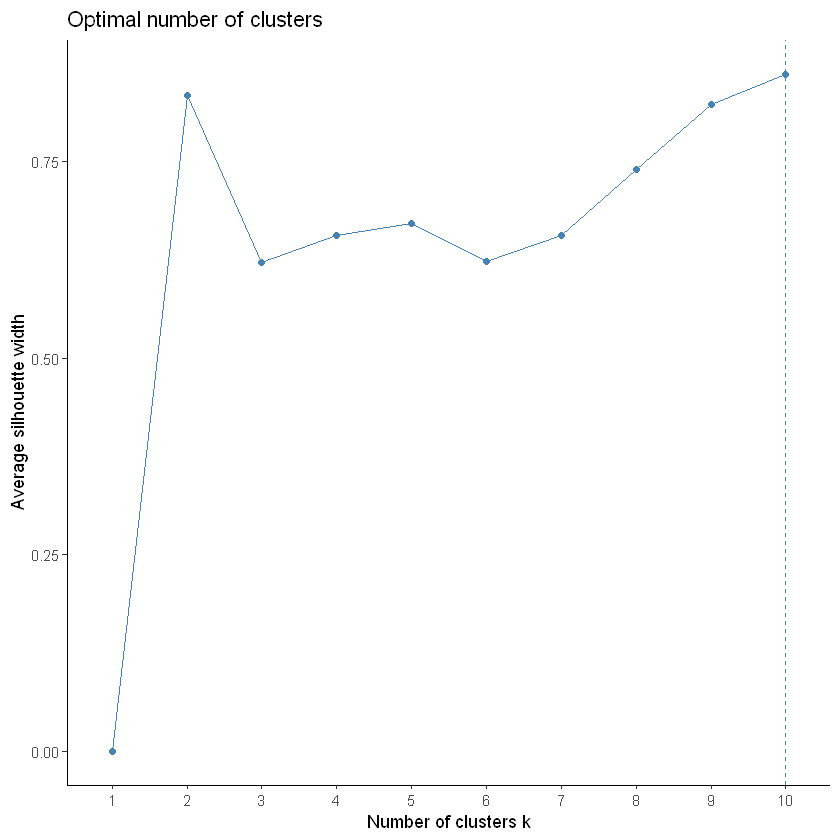

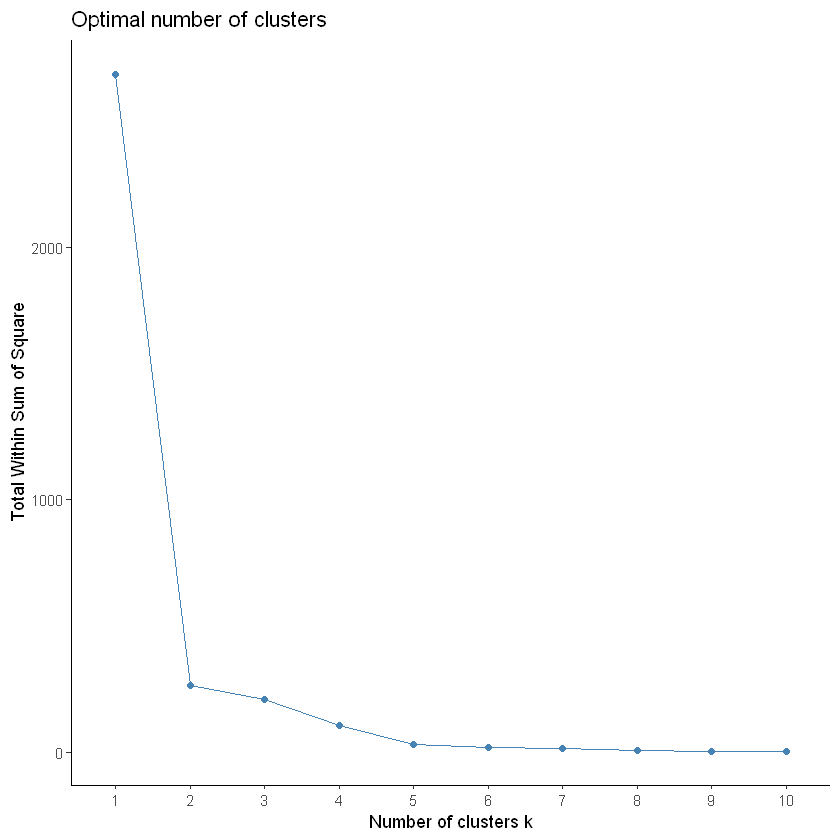

In [18]:
library(factoextra)
fviz_nbclust(ds.toGowerCluster, pam, method="silhouette")+theme_classic()
fviz_nbclust(ds.toGowerCluster, pam, method="wss")+theme_classic()

## PAM

- I will start on implementing *PAM* for Kmedoids.
- The plot below shows the 3 clusters made from my data.
- In the plot, we can clearly see that the **item 14** is in the upper right corner which is the farthest from other items. 
- To validate, we can see in the **Culstering vector** that the **item 14** belongs to cluster 3 while **item 27**  belongs to cluster 1. 
- And the **item 26** and **item 16** from the **Most Similar Pair** are belong to cluster 1. 
- Hence, the distance measurement validates the clustering.

Medoids:
   ID          1          2          3           4         5         6
49 49 0.02928968 0.05650714 0.25559799 0.005157492 0.0375030 0.1790148
24 24 0.18455232 0.11700117 0.09806936 0.173398712 0.1386068 0.0460187
41 41 0.52913596 0.45815395 0.28367993 0.516592749 0.4831905 0.3356463
            7          8          9        10         11         12         13
49 0.04291394 0.03210694 0.07675934 0.3766134 0.19900064 0.04066375 0.12564864
24 0.13476944 0.15773995 0.11305224 0.2065360 0.04750359 0.15478248 0.05558787
41 0.47676668 0.50232359 0.45763587 0.2713810 0.31566045 0.47399734 0.40017151
          14         15         16         17         18         19         20
49 0.7962117 0.02315999 0.01946367 0.02640094 0.13605819 0.24537007 0.03162081
24 0.6261342 0.16360781 0.17159838 0.18166358 0.04011735 0.07529261 0.17206864
41 0.4821323 0.50819145 0.51618202 0.52624722 0.37860290 0.26929103 0.51665227
          21         22        23        24         25         26         2

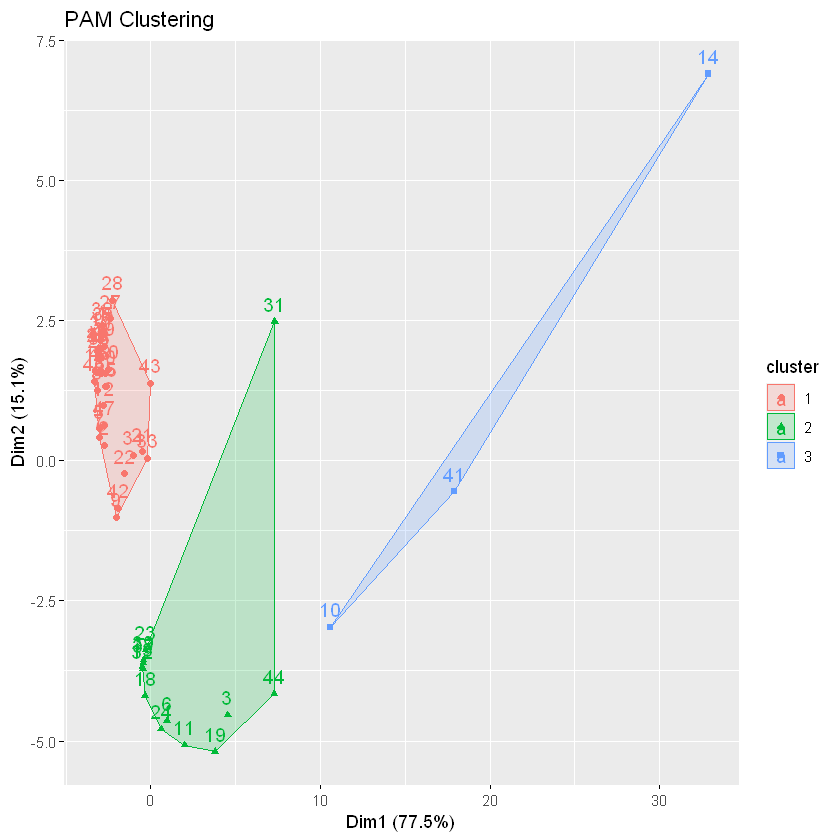

In [19]:

pm <- eclust(distance_matrix,FUNcluster="pam", k=3)
#fviz_cluster(pm,distance_matrix)
print(pm)


### Cluster Interpertation

**As shown in the cluster summary below, :**

1. I can  say that the cluster 1 mainly contain those videos that has the lowest "views", "likes", "dislikes", and "comment_count" and by looking at the "category_id" values, I can say that these videos mostly came from different and non-frequent categories. However, these videos still became trending regardless of date.
 
2. In the 2nd cluster, I observed that the videos here has the middle values in terms of "views", "likes", "dislikes", and "comment_count" and it is also noticeable that the "category_id" became more frequent at 10.
  
3. Lastly, the 3rd cluster seems to have the most trending videos with the highes values in the same attributes except with the "comment_count". Does it mean that, a video doesnt need high comment_count to be trending?. Final observation is that, in this cluster all videos has the "category_id" 10 which is the "Music" category.

  

In [20]:
library(cluster)
pam.fit <- pam(gower_dist, diss = TRUE, k = 3)
pam.res <- ds %>%
  dplyr::select(-"video_id") %>%
  mutate(cluster = pam.fit$clustering) %>%
  group_by(cluster) %>%
  do(the_summary = summary(.))

pam.res$the_summary
ds[pam.fit$medoids,]

[[1]]
     views              likes             dislikes       comment_count    
 Min.   :0.000000   Min.   :0.000000   Min.   :0.00000   Min.   :0.00000  
 1st Qu.:0.003878   1st Qu.:0.004188   1st Qu.:0.01474   1st Qu.:0.01706  
 Median :0.012480   Median :0.022476   Median :0.02914   Median :0.03507  
 Mean   :0.021274   Mean   :0.038279   Mean   :0.05842   Mean   :0.09035  
 3rd Qu.:0.033887   3rd Qu.:0.058064   3rd Qu.:0.07596   3rd Qu.:0.09225  
 Max.   :0.079368   Max.   :0.229081   Max.   :0.28612   Max.   :0.75293  
                                                                          
  category_id     trending_date    cluster 
 Min.   :17.00   18.01.01: 2    Min.   :1  
 1st Qu.:24.00   18.26.01: 2    1st Qu.:1  
 Median :25.00   17.09.12: 1    Median :1  
 Mean   :24.51   17.13.12: 1    Mean   :1  
 3rd Qu.:26.00   17.14.12: 1    3rd Qu.:1  
 Max.   :28.00   17.20.12: 1    Max.   :1  
                 (Other) :27               

[[2]]
     views              likes      

,video_id,views,likes,dislikes,comment_count,category_id,trending_date
15,PT2fxswWSpQ,0.009752585,0.008625351,0.01831306,0.03166293,24,18.16.04
18,aq-phmpUJ_E,0.031191470,0.047716795,0.05774629,0.06112358,10,18.18.03
14,Bm8rz-llMhE,1.000000000,1.000000000,1.00000000,0.49854567,10,18.23.04


## Hierarchical


- To compare with other methods I implemented another algorithms.
- Here, I used Hierchical Clustering in which I've got a Cluster Dendrogram as an output.
- This Dendrogram  shows the distances between each items in my dataset. 
- We can also see here that the top most item is the **item 14** and equivalently **item 27** belongs to the lowest. 


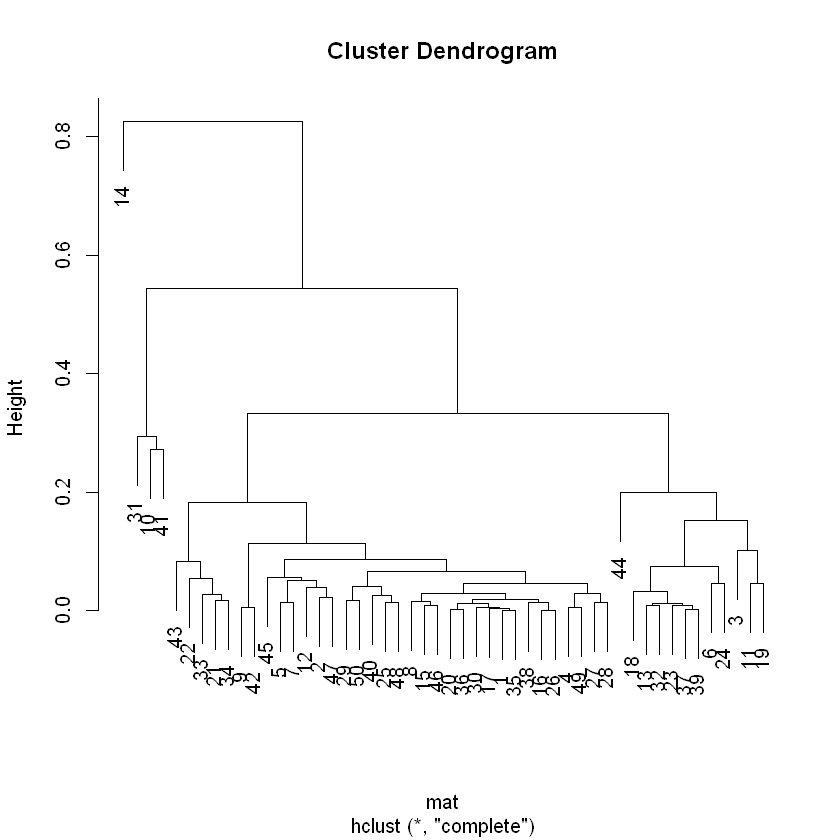

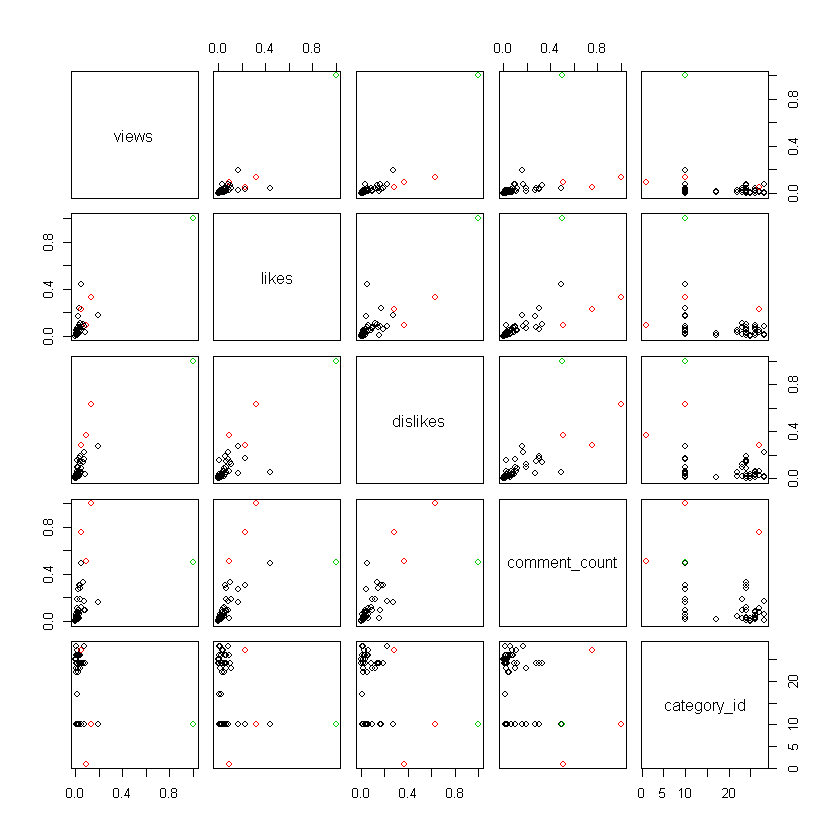

In [21]:

mat = daisy(ds.toGowerCluster, metric = "gower")
hier = hclust(mat)
plot(hier)
res = cutree(hier,3)
plot(ds.toGowerCluster,col=res)


## DBSCAN

- I also implemented DBSCAN for Density-based spatial clustering. 
- This approach is almost identical with Hierarchical Clustering.
- Hence we can clearly see that ther is no much different on result.

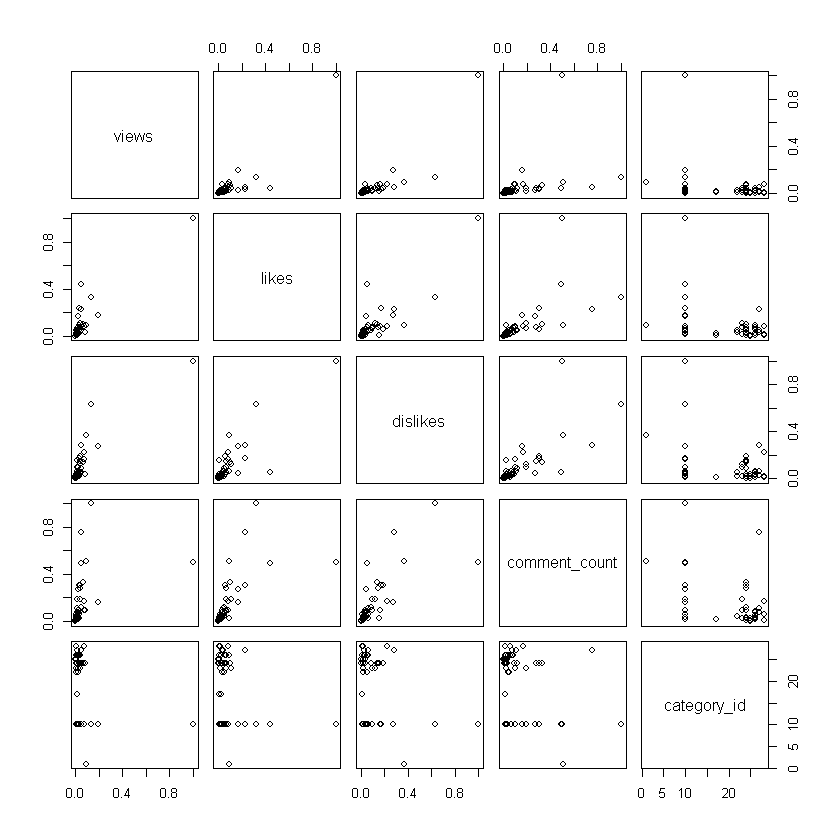

In [22]:
library(fpc)

mat = daisy(ds.toGowerCluster, metric = "gower")
res = dbscan(mat,eps = 3)

plot(ds.toGowerCluster, col=res$cluster)